# Lab: Post-Double Selection

Rely heavily on https://matteocourthoud.github.io/course/ml-econ/09_postdoubleselection/

Before starting we have to install seaborn, to do so open you miniconda prompt and write `pip install seaborn`

In [184]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [185]:
# Import everything
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [186]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## 1 Frisch-Waugh theorem

Consider the data $D = \{ x_i, y_i, z_i \}_{i=1}^n$ with DGP:

$$
y_i = x_i' \alpha_0+ z_i' \beta_0 + \varepsilon_i
$$
. The Frisch-Waugh-Lowell theorem is telling us that there are multiple ways to estimate a single regression coefficient. It shows that the following estimators of $\alpha$ are numerically equivalent:

- OLS: $\hat{\alpha}$ (estimates of $\alpha$) from regressing $y$ on $x, z$
    - the OLS estimator obtained by regressing $y$ on $x$ and $z$
- Partialling out (or residualization): $\tilde{\alpha}$ from regressing $y$ on $\tilde{x}$
    - the OLS estimator obtained by regressing $y$ on $\tilde{x}$, where $\tilde{x}$ is the residual from the regression of $x$ on $z$
- "Double" partialling out: $\bar{\alpha}$ from regressing $\tilde{y}$ on $\tilde{x}$
     - OLS estimator obtained by regressing $\tilde{y}$ on $\tilde{x}$, where  $\tilde{y}$ is the residual from the regression of $y$ on $z$
     
where the operation of passing to $y, x$ to $\tilde{y}, \tilde{x}$ is called *projection  out $z$*, e.g. $\tilde{x}$ are the residuals from regressing $x$ on $z$.

In reality, we have done the following:
 1. regress $x$ on $z$
 2. compute $\hat x$: estimates 
 3. compute the residuals $\tilde x = x - \hat x$
 
 
 Why do we care about the FWT? Well, the DDML and PDS applied it to have consistent and unbiased estimates. 

## 2 Omitted Variable Bias

Consider two separate statistical models. Assume the following **long regression** of interest:

$$
y_i = x_i' \alpha_0+ z_i' \beta_0 + \varepsilon_i
$$

Define the corresponding **short regression** as

$$
y_i = x_i' \alpha_0 + v_i \quad \text{ with } \quad x_i = z_i' \gamma_0 + u_i
$$

#### OVB Theorem

Suppose that the DGP for the long regression corresponds to $\alpha_0$, $\beta_0$. Suppose further that $\mathbb E[x_i] = 0$, $\mathbb E[z_i] = 0$, $\mathbb E[\varepsilon_i |x_i,z_i] = 0$. Then, unless $\beta_0 = 0$ or $z_i$ is orthogonal to $x_i$, the (sole) stochastic regressor $x_i$ is correlated with the error term in the short regression which implies that the OLS estimator of the short regression is inconsistent for $\alpha_0$ due to the omitted variable bias. In particular, one can show that the plim of the OLS estimator of $\hat{\alpha}_{SHORT}$ from the short regression is

$$
\hat{\alpha}_{SHORT} \overset{p}{\to} \frac{Cov(y_i, x_i)}{Var(x_i)} = \alpha_0 + \beta_0 \frac{Cov(z_i, x_i)}{Var(x_i)}
$$

## 3 Pre-Test Bias

Consider data $D= (y_i, x_i, z_i)_{i=1}^n$, where the true model is:

$$
\begin{aligned}
& y_i = x_i' \alpha_0  + z_i' \beta_0 + \varepsilon_i \\
& x_i = z_i' \gamma_0 + u_i
\end{aligned}
$$

Where $x_i$ is the variable of interest (we want to make inference on $\alpha_0$) and $z_i$ is a high dimensional set of control variables. 

From now on, we will work under the following assumptions:

- $\dim(x_i)=1$ for all $n$
- $\beta_0$ uniformely bounded in $n$
- Strict exogeneity: $\mathbb E[\varepsilon_i | x_i, z_i] = 0$ and $\mathbb E[u_i | z_i] = 0$
- $\beta_0$ and $\gamma_0$ have dimension (and hence value) that depend on $n$

Pre-Testing procedure:

1. Regress $y_i$ on $x_i$ and $z_i$
2. For each $j = 1, ..., p = \dim(z_i)$ calculate a test statistic $t_j$
3. Let $\hat{T} = \{ j: |t_j| > C > 0 \}$ for some constant $C$ (set of statistically significant coefficients).
4. Re-run the new "model" using $(x_i, z_{\hat{T},i})$ (i.e. using the selected covariates with statistically significant coefficients).
5. Perform statistical inference (i.e. confidence intervals and hypothesis tests) as if no model selection had been done.

Pre-testing leads to incorrect inference. Why? Because of test errors in the first stage.

In [47]:
np.random.seed(1)

# Init
n = 1000
a = 1
b = -.3
# Generate data
x = np.random.uniform(0,1,n).reshape(-1,1)
z = np.random.uniform(0,1,n).reshape(-1,1)
e = np.random.normal(0,1,n).reshape(-1,1)
y = a*x + b*z + e

In [48]:
# T-test
def t_test(y, x, k):
    beta_hat = inv(x.T @ x) @ x.T @ y
    residuals = y - x @ beta_hat
    sigma2_hat = np.var(residuals)
    beta_std = np.sqrt(np.diag(inv(x.T @ x)) * sigma2_hat )
    return beta_hat[k,0]/beta_std[k]

First of all the t-test for $H_0: \beta_0 = 0$:

$$
t = \frac{\hat \beta_k}{\hat \sigma_{\beta_k}}
$$

where the standard deviation of the ols coefficient is given by

$$
\hat \sigma_{\beta_k} = \sqrt{ \hat \sigma^2 \cdot (X'X)^{-1}_{[k,k]} }
$$

where we estimate the variance of the error term with the variance of the residuals

$$
\hat \sigma^2 = Var \big( y - \hat y \big) = Var \big( y - X (X'X)^{-1}X'y \big)
$$

In [49]:
# Pre-testing
def pre_testing(a, b, c, n, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        x, y, z = generate_data(a, b, c, n)
        xz = np.concatenate([x,z], axis=1)
        
        # Compute coefficients
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance of z on y
        t = t_test(y, xz, 1)
        
        # Select specification based on test
        if np.abs(t)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
    
    return alpha

Let's compare the different estimates.

In [50]:
# Get pre_test alpha
alpha = pre_testing(a, b, c, n)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

Mean alpha Long = 0.9994
Mean alpha Short = 0.9095
Mean alpha Pre-test = 0.9925


The pre-testing coefficient is very close to the true coefficient.

However, the main effect of pre-testing is on inference. With pre-testing, the distribution of the estimator is not gaussian anymore. 

In [51]:
def plot_alpha(alpha, a):
    
    fig = plt.figure(figsize=(17,6))

    # Plot distributions
    x_max = np.max([np.max(np.abs(x-a)) for x in alpha.values()])

    # All axes
    for i, key in enumerate(alpha.keys()):
        
        # Reshape exisiting subplots
        k = len(fig.axes)
        for i in range(k):
            fig.axes[i].change_geometry(1, k+1, i+1)
            
        # Add new plot
        ax = fig.add_subplot(1, k+1, k+1)
        ax.hist(alpha[key], bins=30)
        ax.set_title(key)
        ax.set_xlim([a-x_max, a+x_max])
        ax.axvline(a, c='r', ls='--')
        legend_text = [r'$\alpha_0=%.0f$' % a, r'$\hat \alpha=%.4f$' % np.mean(alpha[key])]
        ax.legend(legend_text, prop={'size': 10})

Let's compare the long, short and pre-test estimators.

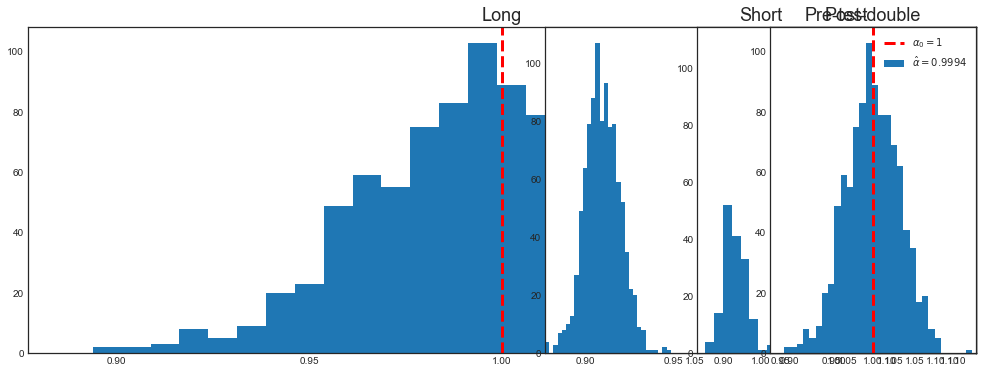

In [57]:
# Plot
plot_alpha(alpha, a)

As we can see, the main problem of pre-testing is inference.

Because of the testing procedure, the distribution of the estimator is a combination of two different distributions: the one resulting from the long regression and the one resulting from the short regression. 

**Pre-testing is not a problem in 3 cases**:

 - when $\beta_0$ is very large: in this case the test always rejects the null hypothesis $H_0 : \beta_0=0$ and we always run the correct specification, i.e. the long regression
 
 - when $\beta_0$ is very small: in this case the test has very little power. However, as we saw from the Omitted Variable Bias formula, the bias is small.
 
 - when $\gamma_0$ is very small: also in this case the test has very little power. However, as we saw from the Omitted Variable Bias formula, the bias is small.

### Pre-Testing and Machine Learning

How are machine learning and pre-testing related? The best example is Lasso. Suppose you have a dataset with many variables. This means that you have very few degrees of freedom and your OLS estimates are going to be very imprecise. At the extreme, you have more variables than observations so that your OLS coefficient is undefined since you cannot invert the design matrix $X'X$.

In this case, you might want to do variable selection. One way of doing variable selection is pre-testing. Another way is Lasso. A third alternative is to use machine learning methods that do not suffer this curse of dimensionality.

The purpose and outcome of pre-testing and Lasso are the same:

 - you **have too many variables**
 - you **exclude some of them from the regression / set their coefficients to zero**
 
As a consequence, also the problems are the same, i.e. pre-test bias.

## 4 Post-Double Selection

Consider again data $D= (y_i, x_i, z_i)_{i=1}^n$, where the true model is:

$$
\begin{aligned}
& y_i = x_i' \alpha_0  + z_i' \beta_0 + \varepsilon_i \\
& x_i = z_i' \gamma_0 + u_i
\end{aligned}
$$

 A good pathway towards motivating procedures which guard against pretest bias is a discussion of classical partitioned regression.

Consider a regression $y_i$ on $x_i$ and $z_i$. $x_i$ is the 1-dimensional variable of interest, $z_i$ is a high-dimensional set of control variables. We have the following procedure:

1. **First Stage** selection: regress $x_i$ on $z_i$. Select the statistically significant variables in the set $S_{FS} \subseteq z_i$
2. **Reduced Form** selection: lasso $y_i$ on $z_i$. Select the statistically significant variables in the set $S_{RF} \subseteq z_i$
3. Regress $y_i$ on $x_i$ and $S_{FS} \cup S_{RF}$

**Theorem**:
Let $\{P^n\}$ be a sequence of data-generating processes for $D_n = (y_i, x_i, z_i)^n_{i=1} \in (\mathbb R \times \mathbb R \times \mathbb R^p) ^n$ where $p$ depends on $n$. For each $n$, the data are iid with $yi =  x_i'\alpha_0^{(n)} + z_i' \beta_0^{(n)} + \varepsilon_i$ and $x_i = z_i' \gamma_0^{(n)} + u_i$ where $\mathbb E[\varepsilon_i | x_i,z_i] = 0$ and $\mathbb E[u_i|z_i] = 0$. The sparsity of the vectors  $\beta_0^{(n)}$, $\gamma_0^{(n)}$ is controlled by $|| \beta_0^{(n)} ||_0 \leq s$ with $s^2 (\log p)^2/n \to 0$. Suppose that additional regularity conditions on the model selection procedures and moments of the random variables $y_i$ , $x_i$ , $z_i$ as documented in Belloni et al. (2014). Then the confidence intervals, CI, from the post double selection procedure are uniformly valid. That is, for any confidence level $\xi \in (0, 1)$
$$
		\Pr(\alpha_0 \in CI) \to 1- \xi
$$

In order to have valid confidence intervals you want their bias to be negligibly. Since
$$
  CI = \left[ \hat{\alpha} \pm \frac{1.96 \cdot \hat{\sigma}}{\sqrt{n}} \right]
$$

If the bias is $o \left( \frac{1}{\sqrt{n}} \right)$ then there is no problem since it is asymptotically negligible w.r.t. the magnitude of the confidence interval. If however the the bias is $O \left( \frac{1}{\sqrt{n}} \right)$ then it has the same magnitude of the confidence interval and it does not asymptotically vanish. 

The idea of the proof is to use partitioned regression. An alternative way to think about the argument is: bound the omitted variables bias. Omitted variable bias comes from the product of 2 quantities related to the omitted variable:

1. Its partial correlation with the outcome, and
2. Its partial correlation with the variable of interest.

If both those partial correlations are $O( \sqrt{\log p/n})$, then the omitted variables bias is $(s \times O( \sqrt{\log p/n})^2 = o \left( \frac{1}{\sqrt{n}} \right)$, provided $s^2 (\log p)^2/n \to 0$. Relative to the $ \frac{1}{\sqrt{n}} $ convergence rate, the omitted variables bias is negligible. 

In our omitted variable bias case, we want $| \beta_0 \gamma_0 | = o \left( \frac{1}{\sqrt{n}} \right)$.  Post-double selection guarantees that 

- *Reduced form* selection (pre-testing): any "missing" variable has $|\beta_{0j}| \leq \frac{c}{\sqrt{n}}$
- *First stage* selection (additional): any "missing" variable has $|\gamma_{0j}| \leq \frac{c}{\sqrt{n}}$


As a consequence, as long as the number of omitted variables is finite, the omitted variable bias is 
$$
	OVB(\alpha) = |\beta_{0j}| \cdot|\gamma_{0j}| \leq \frac{c}{\sqrt{n}} \cdot \frac{c}{\sqrt{n}} = \frac{c^2}{n} = o \left(\frac{1}{\sqrt{n}}\right)
$$

In [58]:
# Pre-testing code
def post_double_selection(a, b, c, n, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1)),
            'Post-double': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        x, y, z = generate_data(a, b, c, n)
        
        # Compute coefficients
        xz = np.concatenate([x,z], axis=1)
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance of z on y (beta hat)
        t1 = t_test(y, xz, 1)
        
        # Compute significance of z on x (gamma hat)
        t2 = t_test(x, z, 0)
        
        # Select specification based on first test
        if np.abs(t1)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
            
        # Select specification based on both tests
        if np.abs(t1)>1.96 or np.abs(t2)>1.96:
            alpha['Post-double'][i] = alpha['Long'][i]
        else:
            alpha['Post-double'][i] = alpha['Short'][i]
    
    return alpha

Let's now repeat the same exercise as above, but with also post-double selection 

In [59]:
# Get pre_test alpha
alpha = post_double_selection(a, b, c, n)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

Mean alpha Long = 0.9994
Mean alpha Short = 0.9095
Mean alpha Pre-test = 0.9925
Mean alpha Post-double = 0.9994


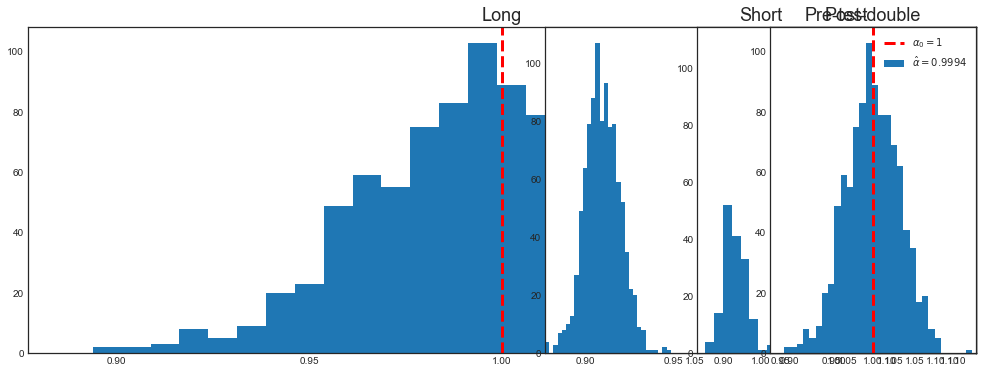

In [56]:
# Plot
plot_alpha(alpha, a)

As we can see, post-double selection has solved the pre-testing problem. Does it work for any magnitude of $\beta$ (relative to the sample size)?

We first have a look at the case in which the sample size is fixed and $\beta_0$ changes.

In [60]:
# Case 1: different betas and same sample size
b_sequence = b*np.array([0.1,0.3,1,3])
alpha = {}

# Get sequence
for k, b_ in enumerate(b_sequence):
    label = 'beta = %.2f' % b_
    alpha[label] = post_double_selection(a, b_, c, n)['Post-double']
    print('Mean alpha with beta=%.2f: %.4f' % (b_, np.mean(alpha[label])))

Mean alpha with beta=-0.03: 0.9994
Mean alpha with beta=-0.09: 0.9994
Mean alpha with beta=-0.30: 0.9994
Mean alpha with beta=-0.90: 0.9994


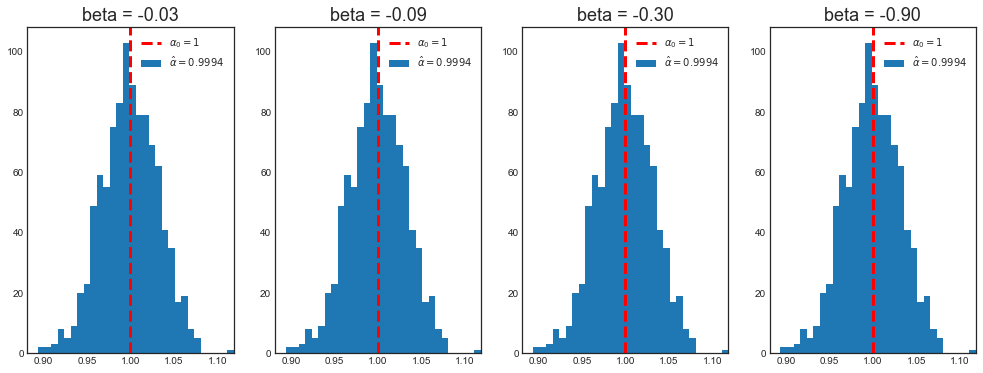

In [26]:
# Plot
plot_alpha(alpha, a)

Post-double selection always selects the correct specification, the long regression, even when $\beta$ is very small.

Now we check the same but for fixed $\beta_0$ and different sample sizes.

In [61]:
# Case 2: same beta and different sample sizes
n_sequence = [100,300,1000,3000]
alpha = {}

# Get sequence
for k, n_ in enumerate(n_sequence):
    label = 'N = %.0f' % n_
    alpha[label] = post_double_selection(a, b, c, n_)['Post-double']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean alpha with n=100: 0.9964
Mean alpha with n=300: 0.9985
Mean alpha with n=1000: 0.9994
Mean alpha with n=3000: 0.9990


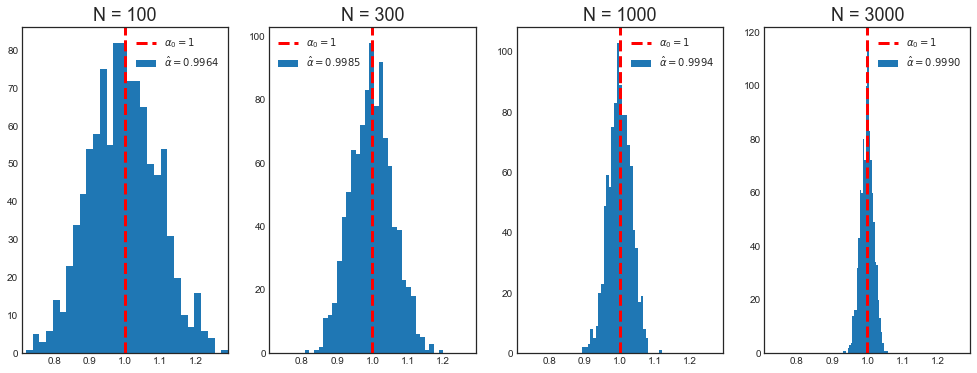

In [28]:
# Plot
plot_alpha(alpha, a)

Post-double selection always selects the correct specification, the long regression, even when the sample size is very small.

Last, we check the case of $\beta_0$ proportional to $\frac{1}{\sqrt{n}}$.

In [62]:
# Case 3: beta proportional to 1/sqrt(n) and different sample sizes
beta =  b * 30 / np.sqrt(n_sequence)

# Get sequence
alpha = {}
for k, n_ in enumerate(n_sequence):
    label = 'N = %.0f' % n_
    alpha[label] = post_double_selection(a, beta[k], c, n_)['Post-double']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean alpha with n=100: 0.9964
Mean alpha with n=300: 0.9985
Mean alpha with n=1000: 0.9994
Mean alpha with n=3000: 0.9990


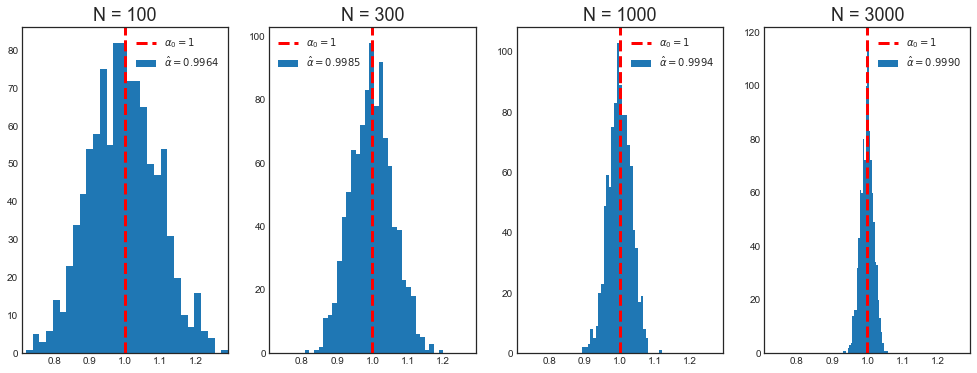

In [30]:
# Plot
plot_alpha(alpha, a)

Once again post-double selection always selects the correct specification, the long regression.

### Post-double Selection and Machine Learning

As we have seen at the end of the previous section, Lasso can be used to perform variable selection in high dimensional settings. Therefore, post-double selection solves the pre-test bias problem in those settings. The post-double selection procedure with Lasso is:

1. **First Stage** selection: lasso $x_i$ on $z_i$. Let the selected variables be collected in the set $S_{FS} \subseteq z_i$
2. **Reduced Form** selection: lasso $y_i$ on $z_i$. Let the selected variables be collected in the set $S_{RF} \subseteq z_i$
3. Regress $y_i$ on $x_i$ and $S_{FS} \cup S_{RF}$

## 5 Double/debiased Machine Learning

This section is based on [Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., & Robins, J. (2018). "*Double/debiased machine learning for treatment and structural parameters*"](https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097).

The objectives are threefold: 
   1. Build a general framework to estimate causal effects using ML
   2. Have confidence intervals for those estimates
   3. Have an estimator with good convergence and efficient properties

It comes from two body of litterature: 
 1. ML which relies on non parametric or semi parametric methods
 2. Theoretical work about non parametric and semi parametric estimation methods
The DML is connexion between them.

Consider the following partially linear model

$$
y = \beta_0 D + g_0(X) + u \\
D = m_0(X) + v
$$

where $y$ is the outcome variable, $D$ is the treatment to interest and $X$ is a potentially high-dimensional set of controls. The dependency in D is modeled through $m_0(X)$ (i.e., effect of $X$ on $D$) and modeled through $g_0(X)$ in $y$.

The objective is to get a root n-consistent estimator and the confidence intervals of $\beta_0$ in presence of the nuisance parameter $\mu_0 = (g_0 ; m_0)$. 

The next natural question is why do we need to use Machine Learning? 
 1. The power of ML for modellign function and/or expecation
 2. ML models are better at predicting than traditional statistical methods when dealing with high-dimensional data
 3. ML does not impose strong assumption on the functional forms of the nuisance parameters but learn these from the data

#### Naive approach

A naive approach to estimation of $\beta_0$ using ML methods would be, for example, to construct a sophisticated ML estimator $\beta_0 D + g_0(X)$ for learning the regression function $\beta_0 D$ + $g_0(X)$.

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0(X)$
3. Use the main sample to compute the orthogonalized component of $Y$ on $X$: $\hat u = \left(Y_{i}-\hat{g}_{0}\left(X_{i}\right)\right)$ 
3. Use the main sample to estimate the residualized OLS estimator

$$
\hat{\beta}_{0}=\left(\frac{1}{n} \sum_{i \in I} D_{i}^{2}\right)^{-1} \frac{1}{n} \sum_{i \in I} D_{i} \hat u_i
$$

This estimator is not the best because of the slow rate of convergence, i.e. slower than $\sqrt(n)$

This estimator is going to be biased (with respect to a normal ditribtuion) because $g_0(X) \neq E[y | x]$. Then, we can't get a good estimate of $g_0(X)$ by regression $y$ on $X$ **BUT** we can have good prediction of $y$ given $X$ and $D$.

The bias comes from two sources:
1. Regularization (we are doign variable selection): solve it using different means of orthogonalization 
2. Overfitting: employ cross-fitting methods

#### Orthogonalization
Remeber the FWL theorem we have seen? It is now time to rely on it.
Now consider a second construction that employs an orthogonalized formulation obtained by directly partialling out the effect of $X$ from $D$ to obtain the orthogonalized regressor $v = D − m_0(X)$.

1. Split the sample in two: main (test) sample and auxiliary (train) sample
2. Use the auxiliary sample to estimate $\hat g_0(X)$ from
    
    $$
    y = \beta_0 D + g_0(X) + u \\
    $$


3. Use the auxiliary sample to estimate $\hat m_0(X)$ from

    $$
    D = m_0(X) + v
    $$


4. Use the main sample to compute the orthogonalized component (residuals) of $D$ on $X$ as

    $$
    \hat v = D - \hat m_0(X)
    $$
    
    
5. Use the main sample to estimate the double-residualized OLS estimator as

    $$
    \hat{\beta}_{0}=\left(\frac{1}{n} \sum_{i \in I} \hat v_i D_{i} \right)^{-1} \frac{1}{n} \sum_{i \in I} \hat v_i \left( Y - \hat g_0(X) \right)
    $$

To summarize, we have predicted $y$ based on $X$ using machine learning (2); predicted $D$ based on $X$ using machine learning (3); then done a linear regression of the residual from $X$ on the predicted value obtained from 2 to have our OLS estimator. 



The estimator is unbiased but still has a lower rate of convergence because of sample splitting. The problem is solved by inverting the split sample, re-estimating the coefficient and averaging the two estimates. Note that this procedure is valid since the two estimates are independent by the sample splitting procedure.

## 6 ML fits into Causal Inference

The traditional Gold Standard for causal inference is multiple regression:
$$
Y_i = \delta D_i + X_i'\beta+\varepsilon_i,
$$
where $D_i$ is the "treatment" or causal variable whose effects we are interested in, and $X_i$ is a vector of controls, $D_i$ is as good as randomly assigned.


> *example:* Suppose we are interested in the magnitude of racial discrimination in the labor market. Can look at the difference in earnings between two workers who are identical in productivity, but differ in their race. Then $D_i$ would be a dummy for being a Black worker. $Y_i$ would be wages, and $X_i$ would be characteristics that capture determinants of productivity.

Can we see this regression as a prediction exercice? For instance, predicting predicting $Y_{i}$ given $D_{i}$ and $X_{i}$.

**Absolutely Not**: we want to estimate a coefficient on $D_{i}$. But we can still use ML to estimate $\delta$.

An equivalent way to estimate $% \delta $ is the following three-step procedure:

1.   Regress $Y_{i}$ on $X_{i}$ and compute the residuals, $\tilde{Y}%
_{i}=Y_{i}-\hat{Y}_{i}^{OLS}$, where $\hat{Y}_{i}^{OLS}=X_{i}^{\prime
}\left( X^{\prime }X\right) ^{-1}X^{\prime }Y$
2.   Regress $D_{i}$ on $X_{i}$ and compute the residuals, $\tilde{D}%
_{i}=D_{i}-\hat{D}_{i}^{OLS}$, where $\hat{D}_{i}^{OLS}=X_{i}^{\prime
}\left( X^{\prime }X\right) ^{-1}X^{\prime }D$

3. Regress $\tilde{Y}_{i}$ on $\tilde{D}_{i}$.

This follows closely the FWL theorem (see section 1.)

Step 1 and 2 are prediction exercises, we can replace OLS with machine learning:

1.   Predict $Y_{i}$ based on $X_{i}$ using ML and compute the residuals, $\tilde{Y}%
_{i}=Y_{i}-\hat{Y}_{i}^{ML}$, where $\hat{Y}_{i}^{ML}$ is the prediction from an ML algorithm
2.   Predict $D_{i}$ based on $X_{i}$ using ML and compute the residuals, $\tilde{D}%
_{i}=D_{i}-\hat{D}_{i}^{ML}$, where $\hat{D}_{i}^{ML}$ is the prediction from an ML algorithm

3. Regress $\tilde{Y}_{i}$ on $\tilde{D}_{i}$.

### Application to AJR02

In [323]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import KFold
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

In this section we are going to replicate 6.3 of the "*Double/debiased machine learning*" paper based on [Acemoglu, Johnson, Robinson (2002), "*The Colonial Origins of Comparative Development*"](https://economics.mit.edu/sites/default/files/publications/colonial-origins-of-comparative-development.pdf).

In their paper, AJR note that their IV strategy will be invalidated if other factors are also highly persistent and related to the development of institutions within a country and to the country’s GDP. A leading candidate for such a factor, as they discuss, is geography. AJR address this by assuming that the confounding effect of geography is adequately captured by a linear term in distance from the equator and a set of continent dummy variables. 

They include their results in table 2.

The objective will be to replicate columns 2, 5, and 6 of Table 2 in AJR.

**Read in data and have a look at it. Data are called AJR02**

Try yourself first

**Solution**

In [301]:
# Load  Dataset
df = pd.read_csv('AJR02.csv',index_col=0)
df.columns

Index(['GDP', 'Exprop', 'Mort', 'Latitude', 'Neo', 'Africa', 'Asia', 'Namer',
       'Samer', 'logMort', 'Latitude2'],
      dtype='object')

In [302]:
df.describe()

GDP     Exprop         Mort   Latitude        Neo     Africa  \
count  64.000000  64.000000    64.000000  64.000000  64.000000  64.000000   
mean    8.062500   6.516094   245.911094   0.190483   0.062500   0.421875   
std     1.043701   1.468841   472.623943   0.145075   0.243975   0.497763   
min     6.110000   3.500000     8.550000   0.000000   0.000000   0.000000   
25%     7.302500   5.617500    68.900000   0.088900   0.000000   0.000000   
50%     7.950000   6.475000    78.150000   0.161150   0.000000   0.000000   
75%     8.852500   7.352500   240.000000   0.267100   0.000000   1.000000   
max    10.220000  10.000000  2940.000000   0.666700   1.000000   1.000000   

            Asia      Namer      Samer    logMort  Latitude2  
count  64.000000  64.000000  64.000000  64.000000  64.000000  
mean    0.140625   0.218750   0.171875   4.646749   0.057002  
std     0.350382   0.416667   0.380254   1.252543   0.086039  
min     0.000000   0.000000   0.000000   2.145931   0.000000  
25%     0.000000   0.000000   0.000000   4.232656   0.007903  
50%     0.000000   0.000000   0.000000   4.358630   0.026000  
75%     0.000000   0.000000   0.000000   5.480639   0.071343  
max     1.000000   1.000000   1.000000   7.986165   0.444489

#### Define outcome and regressor of interest
y = GDP ; d = Exprop
Try it yourself

**Cheat**

In [303]:
y = df['GDP']
d =df[['Exprop']]

#### Simple regression with no controls
regress y on d and print out the coefficient 
1. Fit a linear regression object
2. Print out the results

**Cheat**

In [304]:
lm=linear_model.LinearRegression().fit(d,y)
print("Simple regression protection against expropriation effect on gdp : {:.3f}".format(lm.coef_[0]))

Simple regression protection against expropriation effect on gdp : 0.522


Lets do the same but controlling for a few things: latitude, africa and asia dummy

In [305]:
#Define a constant and add it to X, a matrix of the d and control

# run regressions

#print out coefficient 


#### Solution

In [306]:
# Create lists of variables to be used in each regression
# X includes only control variables
df['const'] = 1
X = df[['Exprop', 'const', 'Latitude', 'Latitude2', 'Asia', 'Africa']]
# run regression
lm.fit(X,y)

print("Simple regression protection against expropriation effect on gdp: {:.3f}".format(lm.coef_[0]))


Simple regression protection against expropriation effect on gdp: 0.409


In [307]:
# This is to do columns 2, 5, and 6 in once
# Create lists of variables to be used in each regression
# Let's add a constant 
df['const'] = 1
d =df[['const','Exprop']]
X = df[['const','Exprop','Latitude', 'Latitude2', 'Asia', 'Africa']]
X2 = df[['const','Exprop', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']]
y = df['GDP']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(y, d, missing='drop').fit()
reg2 = sm.OLS(y, X, missing='drop').fit()
reg3 = sm.OLS(y, X2, missing='drop').fit()

In [308]:
# Make table 2
def make_table_2():

    info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

    results_table = summary_col(results=[reg1,reg2,reg3],
                                float_format='%0.2f',
                                stars = True,
                                model_names=['Model 1','Model 2','Model 3'],
                                info_dict=info_dict,
                                regressor_order=['const','Exprop','Latitude','Latitude2'])
    return results_table

In [309]:
table_2 = make_table_2()
table_2

<class 'statsmodels.iolib.summary2.Summary'>
"""

=========================================
                 Model 1 Model 2  Model 3
-----------------------------------------
const            4.66*** 5.76***  5.95***
                 (0.41)  (0.44)   (0.68) 
Exprop           0.52*** 0.41***  0.40***
                 (0.06)  (0.06)   (0.06) 
Latitude                 0.51     0.42   
                         (1.42)   (1.47) 
Latitude2                0.32     0.44   
                         (2.42)   (2.48) 
Africa                   -0.92*** -1.06**
                         (0.17)   (0.41) 
Asia                     -0.60**  -0.74* 
                         (0.23)   (0.42) 
Namer                             -0.17  
                                  (0.40) 
Samer                             -0.12  
                                  (0.42) 
R-squared        0.54    0.71     0.71   
R-squared Adj.   0.53    0.69     0.67   
No. observations 64      64       64     
=========================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

How does it compare to the simple regression?

**But who is to say the controls we included are sufficient? We have a whole list of  potential controls, not to mention that perhaps the controls we did put in enter linearly. This is a job for ML!** 

Using DML allows us to relax this assumption and to replace it by a weaker assumption that geography can be sufficiently controlled by an unknown function of distance from the equator and continent dummies, which can be learned by ML methods.

In particular, our framework is

$$
{GDP} = \beta_0 \times {Exprop} + g_0({geography}) + u \\
{Exprop} = m_0({geography}) + u
$$

So that the double/debiased machine learning procedure is

1. Split the sample in two: main sample and auxiliary sample
2. Use the auxiliary sample to estimate $\hat g_0({geography})$ from

    $$
    {GDP} = \beta_0 \times {Exprop} + g_0({geography}) + u
    $$


3. Use the auxiliary sample to estimate $\hat m_0({geography})$ from

    $$
    {Exprop} = m_0({geography}) + v
    $$


4. Use the main sample to compute the orthogonalized component of ${Exprop}$ on ${geography}$ as

    $$
    \hat v = {Exprop} - \hat m_0({geography})
    $$


5. Use the main sample to estimate the double-residualized OLS estimator as

    $$
    \hat{\beta}_{0}=\left(\frac{1}{n} \sum_{i \in I} \hat v_i \times {Exprop}_{i} \right)^{-1} \frac{1}{n} \sum_{i \in I} \hat v_i \times \left( {GDP} - \hat g_0({geography}) \right)
    $$

Since we employ an **intrumental variable** strategy, we replace $m_0({geography})$ with $m_0({geography},{logMort})$ in the first stage.

To prep, let's define a matrix X with all of our potential controls:

**Cheat**

In [310]:
X = df[['const','Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer', 'logMort']]

### POST DOUBLE SELECTION ON LASSO

#### 1. Lasso the outcome on X
Try it yourself, do not forget to standardize Xs

#### Cheat

In [311]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = pd.DataFrame(data=scaler.transform(X),columns = X.columns)

lassoy = linear_model.LassoCV(max_iter=1000).fit(X, y)

#### 2. Lasso the treatment on X
Try it yourself. 

In [313]:
d =df[['Exprop']]
lassod = linear_model.LassoCV(max_iter=1000).fit(X, d)

#### 3. Form the union of controls
Try it yourself. Which controls have been selected?

In [314]:
Xunion=X.iloc[:,(lassod.coef_!=0) + (lassoy.coef_!=0)]
Xunion.head()

Latitude2     Asia    Africa   logMort
0   0.466022 -0.40452  1.170628 -0.231331
1  -0.448839 -0.40452  1.170628  0.795064
2   1.004300 -0.40452 -0.854242 -0.333215
3   0.386560 -0.40452 -0.854242 -2.012376
4   0.175522 -0.40452 -0.854242 -0.164235

#### Now Concatenate treatment with union of controls and regress y on that and print out estimate

**Cheat**

In [319]:
# Make sure to reset the index to avoid duplicate values
d = d.reset_index(drop=True)
Xunion = Xunion.reset_index(drop=True)
y = y.reset_index(drop=True)

# Concatenate DataFrames
rhs = pd.concat([d, Xunion], axis=1)
fullreg=linear_model.LinearRegression().fit(rhs,y)
print("PDS protection against expropriation effect on gdp: {:.3f}".format(fullreg.coef_[0]))

PDS protection against expropriation effect on gdp: 0.355


### DOUBLE DEBIASED MACHINE LEARNING

First let's do it without sample splitting

#### Step 1: Ridge outcome on Xs, get residuals

**Cheat**

In [320]:
ridgey = linear_model.RidgeCV().fit(X, y)
yresid=y-ridgey.predict(X)

#### Step 2: Ridge treatment on Xs, get residuals


**Cheat**

In [321]:
ridged = linear_model.RidgeCV().fit(X, d)
dresid=d-ridged.predict(X)

####  Step 3: Regress y resids on d resids and print out estimate

**Cheat**

In [328]:
#Quick and easy way
dmlreg=linear_model.LinearRegression().fit(dresid,yresid)
print("DML regression protection against expropriation effect on gdp {:.3f}".format(dmlreg.coef_[0]))

DML regression protection against expropriation effect on gdp 0.365


In [332]:
# Add a constant to the independent variables for statsmodels
dresid = sm.add_constant(dresid)

# Fit the linear regression model using statsmodels
dmlreg = sm.OLS(yresid, dresid).fit()

# Print the summary table
print(dmlreg.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     42.17
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           1.61e-08
Time:                        10:48:27   Log-Likelihood:                -49.238
No. Observations:                  64   AIC:                             102.5
Df Residuals:                      62   BIC:                             106.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.804e-16      0.066   2.72e-15      1.0

### The real one with sample splitting

In [333]:
# create our sample splitting "object"
kf = KFold(n_splits=5,shuffle=True,random_state=42)

# apply the splits to our Xs
kf.get_n_splits(X)

# initialize columns for residuals
yresid = y*0
dresid = d*0

# Now loop through each fold
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  d_train, d_test = d.iloc[train_index,:], d.iloc[test_index,:]

  # Do DML thing
  # Ridge y on training folds:
  ridgey.fit(X_train, y_train)

  # but get residuals in test set
  yresid.iloc[test_index]=y_test-ridgey.predict(X_test)

  #Ridge d on training folds
  ridged.fit(X_train, d_train)
  #but get residuals in test set
  dresid.iloc[test_index,:]=d_test-ridged.predict(X_test)


# Regress resids
dmlreg=linear_model.LinearRegression().fit(dresid,yresid)

print("DML regression protection against expropriation effect on gdp: {:.3f}".format(dmlreg.coef_[0]))

DML regression protection against expropriation effect on gdp: 0.406


Is it significant? no idea. Let's include standard errors to have an idea

In [334]:
import statsmodels.api as sm
rhs = sm.add_constant(dresid)
model = sm.OLS(yresid, rhs)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     50.55
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           1.39e-09
Time:                        10:48:44   Log-Likelihood:                -55.783
No. Observations:                  64   AIC:                             115.6
Df Residuals:                      62   BIC:                             119.9
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0143      0.075     -0.190      0.8

### Try again but using random forest

### CHEAT

In [335]:
# import random forest
from sklearn.ensemble import RandomForestRegressor
# instantiate random forest objects
rfy=RandomForestRegressor(n_estimators=100)
rfd = rfy

# create our sample splitting "object"
kf = KFold(n_splits=5,shuffle=True,random_state=42)

# apply the splits to our Xs
kf.get_n_splits(X)


# initialize columns for residuals
yresidrf = y*0
dresidrf = d*0

# Now loop through each fold
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  d_train, d_test = d.iloc[train_index,:], d.iloc[test_index,:]

  # Do DML thing
  # Ridge y on training folds:
  rfy.fit(X_train, y_train)

  # but get residuals in test set
  yresidrf.iloc[test_index]=y_test-rfy.predict(X_test)

  #Ridge d on training folds
  rfd.fit(X_train, d_train)
  #but get residuals in test set
  dresidrf.iloc[test_index,:]=d_test-rfd.predict(X_test).reshape(-1,1)


# Regress resids
dmlreg=linear_model.LinearRegression().fit(dresidrf,yresidrf)

print("DML regression protection against expropriation effect on gdp: {:.3f}".format(dmlreg.coef_[0]))
rhs = sm.add_constant(dresidrf)
model = sm.OLS(yresidrf, rhs)
results = model.fit(cov_type='HC3')
print(results.summary())

DML regression protection against expropriation effect on gdp: 0.360
                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     40.02
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           3.11e-08
Time:                        10:48:50   Log-Likelihood:                -51.612
No. Observations:                  64   AIC:                             107.2
Df Residuals:                      62   BIC:                             111.5
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

How does it look like compared to AJR paper? 

## Bonus 
Assignment: do the same methods as above using the National Longitudinal Surveys (NLSY) data.
NLSY97 consists of a nationally representative sample of 8,984 men and women born during the years 1980 through 1984 and living in the United States at the time of the initial survey in 1997. It contains extensive information on respondents’ labor market behavior and educational experiences.

I am asking you to estimate the income race gap. The outcome is the log wage in 2016 (`lnw_2016`) and the *treatment* is a dummy eqals 1 if the individual is black (`black`). 

The dataset is in the code folder and its name is `nlsy97.csv`.

This is at least what I am expecting: 
1. Describe the data: number of observations, meaningful summary statistics (tables or graphics)
2. Simple regression without control variables
3. Post double selection Lasso
4. Double-Debiased Machine learning with sample splitting and with two differents algorithms.
5. Comments the magnitude/sign of the different coefficients obtained.